# TED Predictions
Nathan Walker - March, 2018
Springbaord Capstone 1
Draft Report

## Table of Contents
1. [Introduction](#1 Introduction)  
2. [Data Cleaning](#2 Data Cleaning)  
    [--Metadata: Library and Data Import](#2 Metadata Import)  
    [--Metadata: Data Cleanup](#2 Metadata Cleanup)  
    [--Transcripts: Library and Data Import](#2 Tran Import)  
    [--Transcripts: Data Cleanup](#2 Tran Cleanup)  
3. [Exploratory Data Analysis](#3 EDA)
4. [Modeling](#4 Modeling)  
5. [Results](#5 Results)  

---


## <a id='#1 Introduction'>1. Introduction</a>

TED is a nonprofit that holds multiple conferences about Technology, Entertainment, and Design every year.<sup>[1](https://www.ted.com/about/our-organization)</sup> The process of deciding who speaks at a TED event is rather complicated<sup>[2](http://speaker-nominations.ted.com/)-[3](https://www.ted.com/about/conferences/speaking-at-ted)</sup> and while many talks are engaging and inspiring, some are not well-received.

All recorded talks are available on TED’s YouTube pages, but only the most promising of the bunch are uploaded to the official TED website. Videos on this official site can be rated by users through their choice of up to three predefined category tags, which can be divided into two categories: positive (beautiful, courageous, fascinating, funny, informative, ingenious, inspiring, jaw-dropping, persuasive) and negative (confusing, long-winded, obnoxious, OK, unconvincing). Users are given a search option to view videos that are highly rated in the positive categories (i.e., “Show me videos that are: beautiful” gives a list of the talks that rate high in “beautiful”). 

Because quality content drives TED’s official site’s success, being able to predict the success or failure of a TED talk would be quite valuable. TED employs some unknown system to decide which videos should go on their official site, but even among these hand-selected videos, not all receive overwhelmingly positive reviews. This hand-selection process naturally creates some bias against would-be failures, so unsuccessful videos will be under-represented in the data.  

__The aim of this project is to create a linear regression model that can predict how successful a new video will be, based on some metadata and its transcript.__

A video’s success is defined here as the percentage of positive user ratings it receives. That is, a video with 800 ratings in the _positive_ categories and 200 ratings in the _negative_ categories would have a a positive percent of $\frac{800}{800+200} = 0.80$ or 80%.

Metadata included in this assessment will be discussed in the [Data Cleaning](#2 Metadata Cleanup) and [Modeling](#3 Modeling) sections, but possible factors include video duration, the kind of TED event at which the talk was presented, the number of main speakers involved in the talk, and anything that can be gleaned from the transcripts themselves (e.g., number of "applause" or "laugher" demarcations).

The transcripts themselves will be used by creating a 300-dimension GloVe<sup>[4](https://nlp.stanford.edu/pubs/glove.pdf)</sup> representation of each document. For each word, these representations are created by training a 300-node, single-layer neural network on overall co-occurence counts for a pair of words. The document representation is the sum of all words in a given document. Because these 300 dimensions are unordered and have no intrisic meaning, the model selection process can pick and choose the most informative ones and leave the others out. This process will be explored more fully in the [Modeling](#3 Modeling) section. GloVe representations will be parsed using spaCy's pre-trained web model, which was trained on common crawl data with 685k keys and 685k distinct vectors.<sup>[5](https://spacy.io/models/en#en_core_web_lg)</sup>

## <a id='#2 Data Cleaning'>2. Data Cleaning</a>

A user on Kaggle scraped TED’s online video repository<sup>[6](https://www.ted.com/talks)</sup> on September 21, 2017 and uploaded the dataset to Kaggle.<sup>[7](https://www.kaggle.com/rounakbanik/ted-talks)</sup> There are 2550 videos’ metadata and transcripts in the dataset, in two files. The metadata dataset includes the URL, information on the speaker, the video, community comment counts, and user ratings in different categories (as explained above). The transcript dataset includes the full transcript of each talk, as well as a URL for reference.

To prepare the data for modeling, some preprocessing must take place first.

## <a id='#2 Metadata Import'>Metadata: Library and Data Import</a>

The data is in CSV format, so it can be loaded in and explored using the pandas package. An overview of the data is available here:

In [40]:
# 1. Library and Data Import

# import libraries
import pandas as pd              # CSV loading, dataframes
import matplotlib.pyplot as plt  # Plots
import seaborn as sns            # Pretty Plots
import json                      # Convert ratings column
import re                        # Regex

# import data
df_stats = pd.read_csv('ted_main.csv')

# data preview
print(df_stats.info())
df_stats.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
comments              2550 non-null int64
description           2550 non-null object
duration              2550 non-null int64
event                 2550 non-null object
film_date             2550 non-null int64
languages             2550 non-null int64
main_speaker          2550 non-null object
name                  2550 non-null object
num_speaker           2550 non-null int64
published_date        2550 non-null int64
ratings               2550 non-null object
related_talks         2550 non-null object
speaker_occupation    2544 non-null object
tags                  2550 non-null object
title                 2550 non-null object
url                   2550 non-null object
views                 2550 non-null int64
dtypes: int64(7), object(10)
memory usage: 338.8+ KB
None


,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292


The ouptut above shows that there are 2550 videos with 17 columns of information each. There are no missing rows in any of the important columns and no important columns with datatypes that must be changed.

---

## <a id='#2 Metadata Cleanup'>Metadata: Data Cleanup</a>

There are a few things to be fixed here, but the data looks fairly clean already. The list of data cleaning tasks and their motivation is explained here:

A. Identify and discard duplicate rows (if any).  
B. Remove unneeded columns: __related_talks__, __speaker_occupation__, __comments__, __film_date__, __published_date__, __languages__, __main_speaker__, __speaker_occupation__, __title__, __description__, and __views__. These columns include data outside the scope of this study design.  
C. Group __event__ categories, as there are too many options to be useful here.  
D. Create "percent positive ratings" based on the __ratings__ column.

In [41]:
# A. Identify and discard duplicates.

# identify duplicates based on name
dup_list = df_stats.duplicated(subset='name')

# print index of duplicates (if any)
print("Index of duplicates:", list(dup_list[dup_list == True].index))
print("Number of duplicates:", len(dup_list[dup_list == True]))

Index of duplicates: [] 

Number of duplicates: 0


In [42]:
# B. Remove columns

to_remove = ['related_talks', 'speaker_occupation', 'comments', 'film_date', 'published_date', 'languages', 'main_speaker', 'speaker_occupation', 'title', 'views', 'description']
df_stats.drop(columns=to_remove, inplace=True)

In [43]:
# C. Regroup event column

# C1. Find all events
df_stats.event.value_counts()

TED2014                          84
TED2009                          83
TED2016                          77
TED2013                          77
TED2015                          75
TEDGlobal 2012                   70
TED2011                          70
TEDGlobal 2011                   68
TED2007                          68
TED2010                          68
TED2017                          67
TEDGlobal 2013                   66
TED2012                          65
TEDGlobal 2009                   65
TED2008                          57
TEDGlobal 2010                   55
TEDGlobal 2014                   51
TED2006                          45
TED2005                          37
TEDIndia 2009                    35
TEDSummit                        34
TEDWomen 2010                    34
TED2003                          34
TED2004                          31
TEDWomen 2015                    28
TED2002                          28
TEDGlobal 2007                   27
TEDGlobal 2005              

There are __355__ different events to begin with, but there are quite a few patterns.  

After searching through the un-shortened version of the above list, a few things become clear:

1. There are non-TED events listed here. Because this study is interested in TED talks, these non-TED talks should be excluded. According to TED's website,<sup>[8](https://www.ted.com/about/conferences/past-teds)</sup> all TED events have "TED" in the name, except the "Mission Blue" series. It should also be noted that TED-Ed videos are actually animated video shorts created for online consumption only<sup>[9](https://www.ted.com/about/programs-initiatives)</sup> and should also be excluded.
2. A good list of categories looks like: 
<ul>
    <li>__TED Yearly__: This is the main event, located somewhere in North America every year.
    <li>__TED Global__: The focus and location for this event are international.
    <li>__TEDx__: These independently-organized events are not "TED," strictly speaking, but share the name and vision of the organization.
    <li>__TED@__: Every year, TED partners with a set of businesses and puts on an event, such as TED@UPS or TED@Intel, with speakers from those companies.
    <li>__TED Women__: These events focus on women's abilities to be and create change in the world.
    <li>__TED Salon__: Instead of a full-on TED event, these events last just an evening.
    <li>__TEDMED__: A focus on health and healthcare from all alngles make these yearly events unique.
    <li>__Other__: There have been plenty of one-off events all over the world with many different focuses. This is the catch-all category for any event or type of event with less than 50 videos in the TED archives.
</ul>

In [44]:
# C2. Categorize

other_list = list()
def event_categorizer(event):
    """
    Returns event type based on event text.
    """
    import re
    
    if re.search('TED[0-9]{4}', event):
        return 'TED Yearly'
    elif re.search('TEDGl', event):
        return 'TED Global'
    elif re.search('TEDx', event):
        return 'TEDx'
    elif re.search('TED@|TEDIndia|TEDNYC', event):
        return 'TED@'
    elif re.search('Salon', event):
        return 'TED Salon'
    elif re.search('Women', event):
        return 'TED Women'
    elif re.search('TEDMED', event):
        return 'TEDMED'
    elif re.search('TED-Ed', event):
        return 'Exclude'
    elif re.search('TED|Mission Blue', event):
        return 'Other'
    else:
        return 'Exclude'

# apply to df
df_stats['event_type'] = df_stats['event'].apply(event_categorizer)

In [45]:
# C3 . Look at new category counts

df_stats.event_type.value_counts()

TED Yearly    978
TEDx          471
TED Global    464
Other         158
TED@          141
TED Women      96
Exclude        95
TED Salon      79
TEDMED         68
Name: event_type, dtype: int64

In [46]:
# C4. Remove non-TED videos

df_stats = df_stats.loc[df_stats.event_type != "Exclude", :].copy()

In [47]:
# D. Convert each 'rating' count into a "percent positive" number

# D1. Convert 'rating' from string to dictionary

def rating_to_dict(rating):
    """
    Converts string representation of list of dictionaries/JSON items into dictonary based on 'name'.
    """
    import json  # easy load-in from string
    import re

    # ignore square brackets, split by curly braces
    match = re.findall("\{.*?\}", rating[1:-1])
    rate_dict = dict()  # empty dict for adding

    for i in match:
        i = i.replace("'", "\"")  # json requires double quotes
        i = json.loads(i)  # curly braced string to dict
        # {rating_name:count} as key:value pair
        rate_dict[i['name']] = i['count']

    return rate_dict

# Apply to df
df_stats.loc[:, 'ratings'] = df_stats.loc[:, 'ratings'].apply(rating_to_dict)

In [48]:
# D2. Find all ratings

all_ratings = set()

for i in df_stats.loc[:, 'ratings']:  # iterate through rows
    k = list(i.keys())  # return list of dictionary keys (categories)
    all_ratings.update(k)  # add new entries, if any

In [49]:
# D3. Create column of percent_positive rating counts

pos_rating = list([
    'Beautiful', 'Courageous', 'Fascinating', 'Funny', 'Informative',
    'Ingenious', 'Inspiring', 'Jaw-dropping', 'Persuasive'
])

neg_rating = list(['Confusing', 'Longwinded', 'Obnoxious', 'Ok', 'Unconvincing'])

def get_pos_pct(x):
    
    pos = 0
    for i in pos_rating:
        icount = x.get(i)
        if icount:
            pos += icount
        
    neg = 0
    for j in neg_rating:
        jcount = x.get(j)
        if jcount:
            neg += jcount
        
    return pos/(pos + neg)

df_stats['pos_pct'] = df_stats['ratings'].apply(get_pos_pct)

In [50]:
# D4 . Remove 'ratings' column to reduce clutter

df_stats.drop(columns='ratings', inplace=True)

# preview data
df_stats.head()

,duration,event,name,num_speaker,tags,url,event_type,pos_pct
0,1164,TED2006,Ken Robinson: Do schools kill creativity?,1,"['children', 'creativity', 'culture', 'dance',...",https://www.ted.com/talks/ken_robinson_says_sc...,TED Yearly,0.987721
1,977,TED2006,Al Gore: Averting the climate crisis,1,"['alternative energy', 'cars', 'climate change...",https://www.ted.com/talks/al_gore_on_averting_...,TED Yearly,0.793633
2,1286,TED2006,David Pogue: Simplicity sells,1,"['computers', 'entertainment', 'interface desi...",https://www.ted.com/talks/david_pogue_says_sim...,TED Yearly,0.868932
3,1116,TED2006,Majora Carter: Greening the ghetto,1,"['MacArthur grant', 'activism', 'business', 'c...",https://www.ted.com/talks/majora_carter_s_tale...,TED Yearly,0.957178
4,1190,TED2006,Hans Rosling: The best stats you've ever seen,1,"['Africa', 'Asia', 'Google', 'demo', 'economic...",https://www.ted.com/talks/hans_rosling_shows_t...,TED Yearly,0.987782


Now that the __metadata__ dataset is cleaned, the focus can turn to preparing the transcripts for GloVe representation.

## <a id='#2 Tran Import'>Transcripts: Library and Data Import</a>

The transcripts are also CSVs, so they can be loaded in through pandas for further exploration.

In [51]:
# 1. Library and Data Import

import spacy.lang.en  # GloVe parsing

# load language models
nlp = spacy.load('en_core_web_lg')

# import data
df_trans = pd.read_csv('transcripts.csv')
df_trans.info()
df_trans.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467 entries, 0 to 2466
Data columns (total 2 columns):
transcript    2467 non-null object
url           2467 non-null object
dtypes: object(2)
memory usage: 38.6+ KB


,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


The data above shows that the data consists of just two columns: __transcript__ and __url__. Unfortunatley, there are transcripts for 2467 of the 2550 videos.

## <a id='#2 Tran Cleanup'>Transcripts: Data Cleanup</a>

The goal in this section is to join the transcript to the correct metadata, fill in any missing data (if possible), remove non-talk information in the transcripts, and find GloVe representations for each row. In outline:

A. Identify and discard duplicates  
B. Join datasets  
C. Identify and fill missing data, where possible  
D. Clean text  
E. Parse text

In [52]:
# A. Identify and discard duplicates

# boolean mask of duplicates by URL
dup_trans_u = df_trans.duplicated(subset='url')

# discard duplicates
df_trans = df_trans[~dup_trans_u]

In [53]:
# B. Join datasets

# join on 'url'
df_ted = df_stats.join(df_trans.set_index('url'), on='url')

# get new dataframe info
df_ted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2455 entries, 0 to 2549
Data columns (total 9 columns):
duration       2455 non-null int64
event          2455 non-null object
name           2455 non-null object
num_speaker    2455 non-null int64
tags           2455 non-null object
url            2455 non-null object
event_type     2455 non-null object
pos_pct        2455 non-null float64
transcript     2408 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 191.8+ KB


The datasets have been successfully joined, but 47 transcripts are missing. 

In [54]:
# C. Identify and fill missing data, where possible

# C1. find missing data
df_ted.loc[df_ted['transcript'].isna(), ['name', 'event_type', 'duration', 'pos_pct']].sort_values('event_type')

,name,event_type,duration,pos_pct
1467,Katherine Kuchenbecker: The technology of touch,Other,388,0.960469
135,"Vusi Mahlasela: ""Woza""",TED Global,299,0.963883
209,"Rokia Traore: ""M'Bifo""",TED Global,419,0.967555
237,"Rokia Traore: ""Kounandi""",TED Global,386,0.955075
696,Sophie Hunger: Songs of secrets and city lights,TED Global,1384,0.889371
547,Matthew White: The modern euphonium,TED Global,141,0.670236
58,"Pilobolus: A dance of ""Symbiosis""",TED Yearly,825,0.974089
2407,"Silk Road Ensemble: ""Turceasca""",TED Yearly,389,0.961290
512,Vishal Vaid: Hypnotic South Asian improv music,TED Yearly,814,0.631052
2418,"Sō Percussion: ""Music for Wood and Strings""",TED Yearly,609,0.725806


Looking at the above snippets of names, descriptions, events, and durations, it seems a couple of things are going on in the data. 

1. Some of the "talks" are actually some kind of performace (music, dance, poetry, etc.) and lack a transcript.
2. The only non-performance talks with no transcripts are from TEDx (independent TED events).

Because this project deals with "talks," all of the videos with no actual "talk" should be removed, whether or not they have a transcript. In instances where there are both a "talk" and a performance, the transcript should be included with the lyrics removed (if given). 

It is unclear whether these transcripts were left out because they were unavialable or because of an automation error. All URLs must be visited to see whether a transcript is (now) available and imported where appropriate.

In [55]:
# C2. Manually check for transcript availability

# print, then visit each in this list (omitted for formatting)
missing_urls = df_ted.loc[(df_ted['transcript'].isna()), 'url']

Ten transcripts had been added since September 21, 2017. Because the data is now available, the missing transcripts were copied to a text document and need to be incorporated into the dataset now.

In [56]:
# C3. Import New Transcripts

with open('raw_transcripts.txt', 'r') as file:
    text = file.readlines()  # read each line in as a list
    
text_dict = dict()  # initialize dict for talks
talk = ""
for line in text:
    if line == '\n':  # skip newlines
        continue
    elif line[0:4] == 'http':  # talks are identified by URL
        talk = line  # create new dict key for each URL
        text_dict[talk] = ""  # set dict key as URL and value as blank string
    elif re.match('\d\d', line):  # skip timestamps
        continue
    else:
        text_dict[talk] += line  # append each line to the last

In [57]:
# C4 . Add New Transcripts

df_ted.set_index('url', inplace=True)  # index by URL
for url, text in text_dict.items():  # iterate through dictionary
    df_ted.loc[url, 'transcript'] = text  # from dictionary: {URL: transcript text}
df_ted.reset_index(inplace=True)  # put URL back as a column and re-index by arbitrary integers

In [58]:
# C5. Remove talks with no transcript
drop_indices = df_ted.loc[df_ted['transcript'].isna(), :].index  # indices to drop
df_ted.drop(drop_indices, inplace=True)

In [59]:
# D. Clean text

# D1. View text sample for example problems
df_ted.loc[5, 'transcript'][:1000]

'Thank you. I have to tell you I\'m both challenged and excited. My excitement is: I get a chance to give something back. My challenge is: the shortest seminar I usually do is 50 hours.(Laughter)I\'m not exaggerating. I do weekends — I do more, obviously, I also coach people — but I\'m into immersion, because how did you learn language? Not just by learning principles, you got in it and you did it so often that it became real.The bottom line of why I\'m here, besides being a crazy mofo, is that — I\'m not here to motivate you, you don\'t need that, obviously. Often that\'s what people think I do, and it\'s the furthest thing from it. What happens, though, is people say to me, "I don\'t need any motivation." But that\'s not what I do. I\'m the "why" guy. I want to know why you do what you do.What is your motive for action? What is it that drives you in your life today? Not 10 years ago. Are you running the same pattern? Because I believe that the invisible force of internal drive, activ

There are a few issues with the text as-is:
1. All of the newlines are missing, causing the last word of one line to be mashed up with the first of the next.
2. There are sounds and audience responses in parentheses, which are not part of the text. Having a count of these instances, however, could be useful.

In [60]:
# D2. Create counts of all things in parentheses

def export_parens(x):
    """
    Creates counts of all things in parentheses
    """
    from collections import Counter
    
    parens = re.findall('\(.+?\)', x)  # finds all things between parenthes and creates list of them
    for i in range(len(parens)):
        parens[i] = parens[i][1:-1]
    counts = Counter(parens)
    
    return counts

# create column of parentheses counts
df_ted.loc[:, 'parentheses'] = df_ted.loc[:, 'transcript'].apply(export_parens)

from collections import Counter
parens = df_ted.loc[:, 'parentheses'].sum()

print("30 most common: \n", parens.most_common(30))
print("\n How many different parentheses: \n", len(parens))


30 most common: 
 [('Laughter', 9975), ('Applause', 5375), ('Music', 600), ('Video', 332), ('Audio', 56), ('Laughs', 51), ('Singing', 45), ('Music ends', 44), ('Applause ends', 42), ('Cheers', 40), ('Beatboxing', 23), ('English', 17), ('Cheering', 16), ('Whistling', 16), ('k', 16), ('Sighs', 15), ('Guitar', 14), ('Guitar strum', 14), ('Sings', 13), ('Audience', 12), ('Beep', 12), ('Clicks metronome', 12), ('Drum sounds', 10), ('Marimba sounds', 10), ('Clapping', 10), ('Beeps', 9), ('Drums', 9), ('In Chinese', 9), ('Arabic', 9), ('Laughter ends', 8)]

 How many different parentheses: 
 820


It is apparent that not all of the parentheses are audience sounds and in some cases, the transcript doesn't have a close-parentheses, meaning some of the actual text is combined in these instances (not shown above). Of the 820 different options, "Laughter" and "Applause" are the most common. The top 30 by count show that the majority show up less than 10 times. It seems reasonable that filtering out the top 30 should catch most of the garbage text without removing the actual transcripts.

Music also shows up, so talks that are actually just lyrics with little to no "talk" need to be filtered out. Looking at these "music" transcripts, it can be seen that all lyrics are surrounded by "♫" symbols. Taking out everything between the "♫" symbols and then filtering out talks with little to no remaining text should leave actual "talks."

Finally, because things like music, dance, and video have an impact that cannot be captured through the transcript, getting a count of the number of times they are shown could be useful. Similarly, perhaps the number of times "(Laughter)" or "(Applause)" shows up could give us an indicator of how positively or negatively a talk was received.

In [61]:
# D3. Create Counters for laughter, applause, and music

def parens_adder(x, cats):
    assert type(cats) == list
    total = 0    
    for i in cats:
        icount = x.get(i)
        if icount:
            total += icount  
    return total
     
df_ted.loc[:, 'laughter'] = df_ted.loc[:, 'parentheses'].apply(parens_adder, cats=['Laughter', 'Laughs'])
df_ted.loc[:, 'applause'] = df_ted.loc[:, 'parentheses'].apply(parens_adder, cats=['Applause', 'Cheers', 'Cheering', 'Whistling', 'Clapping'])
df_ted.loc[:, 'music'] = df_ted.loc[:, 'parentheses'].apply(parens_adder, cats=['Singing', 'Beatboxing', 'Guitar', 'Guitar strum', 'Sings', 'Clicks metronome', 'Drum sounds', 'Marimba sounds', 'Drums'])

In [62]:
# D4. Create boolean columns for lyrics, music, and dance

df_ted.loc[:, 'has_note'] = df_ted.loc[:, 'transcript'].apply(lambda x: bool(re.search("♫|♪", x)))
df_ted.loc[:, 'has_music'] = df_ted.loc[:, 'tags'].apply(lambda x: 'music' in x)
df_ted.loc[:, 'has_dance'] = df_ted.loc[:, 'tags'].apply(lambda x: 'danc' in x)

for i in list(df_ted.index):
    if ((df_ted.loc[i, 'music'] > 0) or (df_ted.loc[i, 'has_note'] == True)) and (df_ted.loc[i, 'has_music'] == False):
        df_ted.loc[i, 'has_music'] = True
        
remove_me = ['music']        
df_ted.drop(columns='music', inplace=True)

In [63]:
# D5. Remove everything between high-count parentheses and music notes

remove_list = list()
for i in parens.most_common(30):
    remove_list.append("\("+i[0]+"\)")
remove_list = "|".join(remove_list)
remove_list += '|♫.+?♫|♪.+?♪'

def remove_paren_music(x):
    x = re.sub(remove_list, ' ', x)
    return x

df_ted.loc[:, 'transcript'] = df_ted.loc[:, 'transcript'].apply(remove_paren_music)

In [64]:
# D6. Add space after all final punctuation

def space_after(match):
    return match.group(0) + " "

def space_before(match):
    return " " + match.group(0)

def add_spaces(x):
    x = re.sub('\."*|\!"*|\:"*|;"*|\)"*|\?"*', space_after, x)
    x = re.sub('"*\(', space_before, x)
    x = ' '.join(x.split())
    return x

df_ted.loc[:, 'transcript'] = df_ted.loc[:, 'transcript'].apply(add_spaces)

df_ted.loc[:, 'char_length'] = df_ted.loc[:, 'transcript'].apply(len)

for i in df_ted.loc[(df_ted['char_length'] < 1000), 'transcript']:
    print(i, "\n")

I'd like to begin this song I wrote about ceaseless yearning and never-ending want with a poem of popular Petrarchan paradoxes by Sir Thomas Wyatt the Elder: "I find no peace, and all my war is done; I fear and hope, I burn and freeze like ice; I fly above the wind, and yet I cannot arise; And naught I have, and all the world I seize upon." 

Okay. Everyone! Chris Anderson: Jill Sobule! 

Thank you very much. Now, I've got a story for you. When I arrived off the plane, after a very long journey from the West of England, my computer, my beloved laptop, had gone mad, and had — oh! — a bit like that! — and the display on it — anyway, the whole thing had burst. And I went to the IT guys here and a gentleman mended my computer, and then he said, "What are you doing here?" and I said "I'm playing the cello and I'm doing a bit of singing," and he said, "Oh, I sort of play the cello as well." And I said, "Do you really?" Anyway, so you're in for a treat, because he's fantastic, and his name's 

Isadora Duncan — — crazy, long-legged woman from San Francisco, got tired of this country, and she wanted to get out. Isadora was famous somewhere around 1908 for putting up a blue curtain, and she would stand with her hands over her solar plexus and she would wait, and she would wait, and then, she would move. Josh and I and Somi call this piece "The Red Circle and the Blue Curtain." Red circle. Blue curtain. But, this is not the beginning of the 20th century. This is a morning in Vancouver in 2015. Come on, Josh! Go! Are we there yet? I don't think so. Hey, yeah! What time is it? Where are we? Josh. Somi. Bill T. Josh. Somi. Bill T. Yeah, yeah! 

 

(Guitar music starts) (Distorted guitar music starts) (Ambient/guitar music starts) 

(Guitar music starts) 



The transcripts above are those that have less than a thousand characters remaining. A glance at talks with 1000-2000 characters remaining shows that most are actual talks, but that one has song lyrics that were not enclosed in music notes like the others. These should all be removed.

In [65]:
# D7. Remove transcripts with less than 1000 characters or only lyrics
df_ted = df_ted.loc[df_ted['char_length'] > 1000, :]
df_ted.drop(2382, inplace=True)

In [66]:
# E. Parse text

# load language models
nlp = spacy.load('en_core_web_lg')

# initialize variables
vector = []
parsed = []

# run parsing in spaCy
for doc in nlp.pipe(df_ted['transcript'].astype('unicode').values, batch_size=800):
    if doc.is_parsed:
        parsed.append(doc)
        vector.append([n.vector for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        parsed.append(None)
        vector.append(None)
        
df_ted['transcript_parsed'] = parsed
df_ted['transcript_vector'] = vector
df_ted.loc[:, 'doc_vector'] = df_ted.loc[:, 'transcript_vector'].apply(lambda x: sum(x))

for i in range(300):
    df_ted[str(i)] = df_ted['doc_vector'].apply(lambda x: x[i])

## <a id='#3 EDA'>3. Exploratory Data Analysis</a>

Before modeling the data, some visual exploration of the relationship between the variables should be done.

For continuous data not included in the 300 GloVe columns:
1. Describe data (count, mean, std, min, max)
2. Create histogram with rug plot
3. Create boxplot
4. Create scatterplot comparing all other continuous varaibles
5. Create heatmap of appropriate correlation statistic for all other continuous variables

For categorical data:
1. Create boxplot comparing levels for the outcome variable (positive rating percent)

In [67]:
# 1. EDA functions

# continuous data
def desc_hist_box(column, data):
    print("Data for", column, ": \n")
    print(data[column].describe())
    
    h = sns.distplot(data[column], kde=False, rug=True)
    h = plt.title('Histogram with Rug Plot')
    h = plt.show()
    
    b = sns.boxplot(data[column])
    b = plt.title('Box Plot')
    b = plt.show()
    
# categorical data    
def desc_pair(col1, col2, data):
    from scipy.stats import pearsonr, spearmanr
    print('Columns:', col1, "&", col2, '\n')
    
    sns.regplot(col1, col2, data)
    plt.show()
    
    sr = spearmanr(data[col1], data[col2])
    print("Spearman's rho:", sr[0])
    print("p-value for Spearman's rho:", sr[1], "\n")

Data for pos_pct : 

count    2381.000000
mean        0.920318
std         0.086317
min         0.195563
25%         0.901540
50%         0.949315
75%         0.974321
max         1.000000
Name: pos_pct, dtype: float64


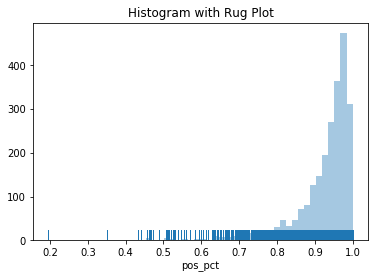

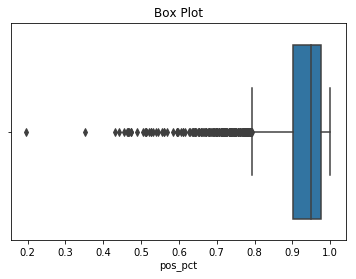

---------------------------
Data for duration : 

count    2381.000000
mean      821.763125
std       327.161291
min       135.000000
25%       587.000000
50%       850.000000
75%      1044.000000
max      3608.000000
Name: duration, dtype: float64


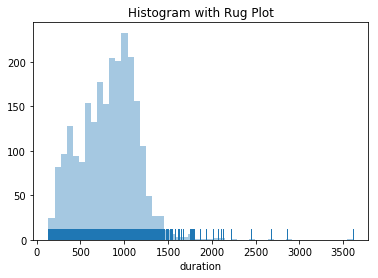

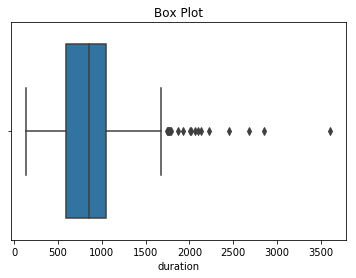

---------------------------
Data for num_speaker : 

count    2381.000000
mean        1.024780
std         0.198247
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: num_speaker, dtype: float64


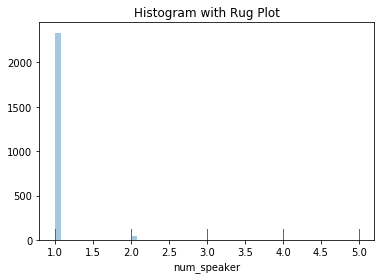

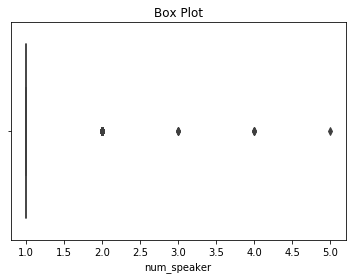

---------------------------
Data for laughter : 

count    2381.000000
mean        4.203276
std         6.160924
min         0.000000
25%         0.000000
50%         2.000000
75%         5.000000
max        74.000000
Name: laughter, dtype: float64


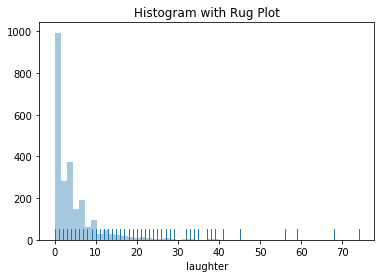

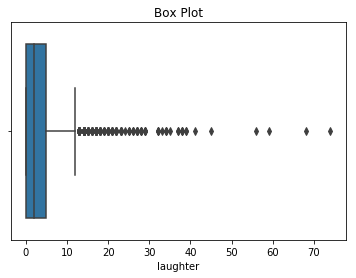

---------------------------
Data for applause : 

count    2381.000000
mean        2.255775
std         2.091925
min         0.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        18.000000
Name: applause, dtype: float64


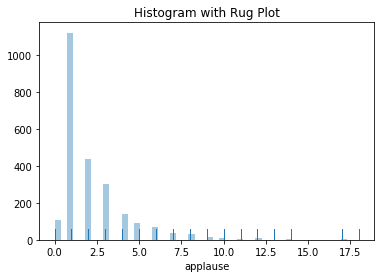

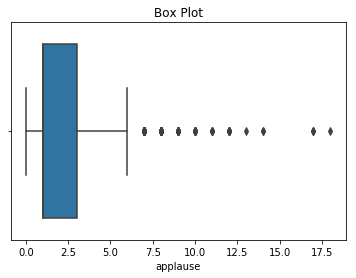

---------------------------


In [68]:
# EDA: Continuous Data, one-by-one
for i in ['pos_pct', 'duration', 'num_speaker', 'laughter', 'applause']:
    desc_hist_box(i, df_ted)
    print('---------------------------')

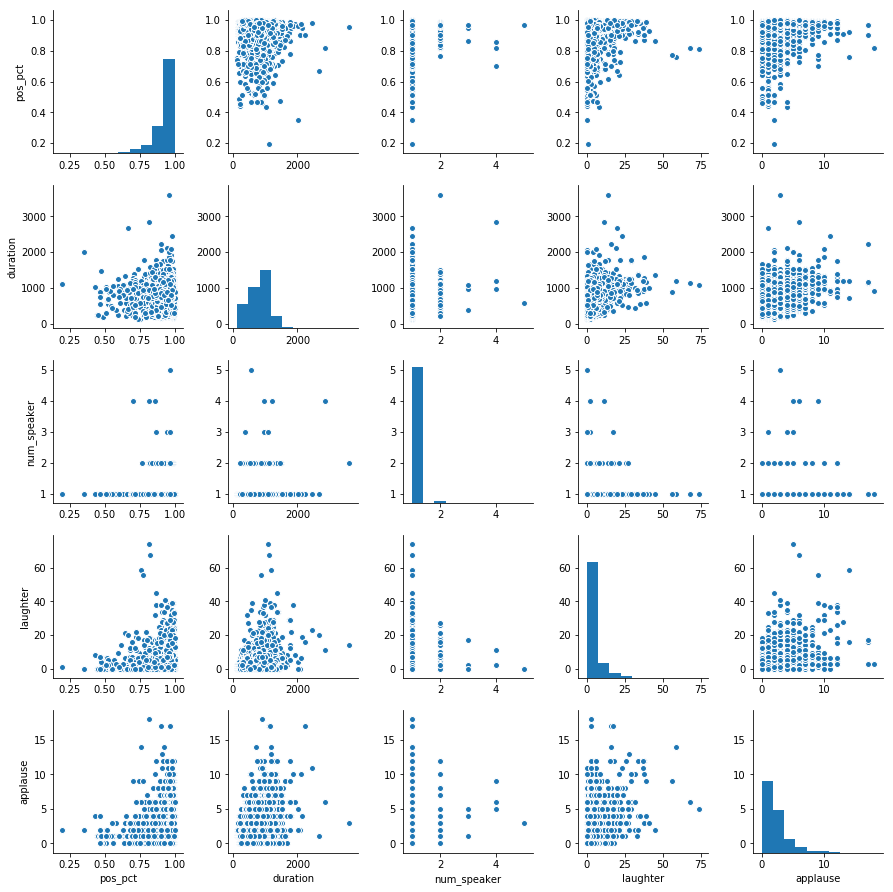

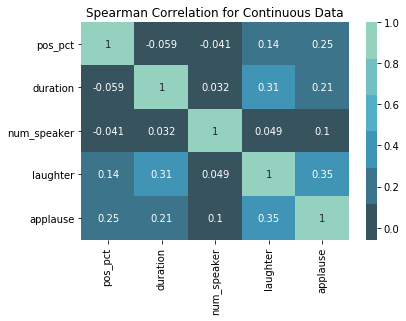

In [69]:
# EDA: Continuous Comparison

# pairplot
_ = sns.pairplot(data=df_ted, vars=['pos_pct', 'duration', 'num_speaker', 'laughter', 'applause'])
_ = plt.show()

# correlation heatmap
df_corr = df_ted.loc[:, ['pos_pct', 'duration', 'num_speaker', 'laughter', 'applause']].corr(method='spearman')
heat = sns.heatmap(df_corr, annot=True, cmap=sns.color_palette("GnBu_d"))
heat = plt.title("Spearman Correlation for Continuous Data")
heat = plt.show()

The results above show a few important issues:
1. There are significant outliers in __duration__.  TED talks are supposed to last no more than 18 minutes, according to official submission guidelines, but some go to 30 minutes or over an hour.
2. Most talks were given by one person and the data is sparse otherwise. Changing __num_speaker__ to a binary variable for "has more than one speaker" could be more useful. 
3. The distributions for __laughter__ and __applause__ have mostly 0's and 1's. This indicates that transcribers were likely not consistent in their in-/exclusion of audience reactions and their use for prediction may be inconsistent.
4. The distribution for __pos_pct__, the dependent variable, is skewed toward higher values. This may cause underfitting for poorly-rated talks.

In [70]:
# EDA: Address continuous issues
#1. Significant outliers in duration
df_ted.loc[df_ted['duration'] > 25*60, ['name', 'duration', 'event_type']]

,name,duration,event_type
11,Jehane Noujaim: My wish: A global day of film,1538,TED Yearly
12,Larry Brilliant: My wish: Help me stop pandemics,1550,TED Yearly
39,Bono: My wish: Three actions for Africa,1672,TED Yearly
40,Edward Burtynsky: My wish: Manufactured landsc...,2065,TED Yearly
41,Robert Fischell: My wish: Three unusual medica...,1609,TED Yearly
66,Jane Goodall: What separates us from chimpanzees?,1645,TED Yearly
89,Evelyn Glennie: How to truly listen,1929,TED Yearly
96,Richard Dawkins: Militant atheism,1750,TED Yearly
146,Stephen Petranek: 10 ways the world could end,1782,TED Yearly
150,"Richard Branson: Life at 30,000 feet",1791,TED Yearly


Most talks over 25 minutes look to be from _TED Yearly_ or _TED Global_ talks and from well-known individuals, sometimes in controversial topics. This indicates they are something different from the normal TED talk and should be excluded as outliers.

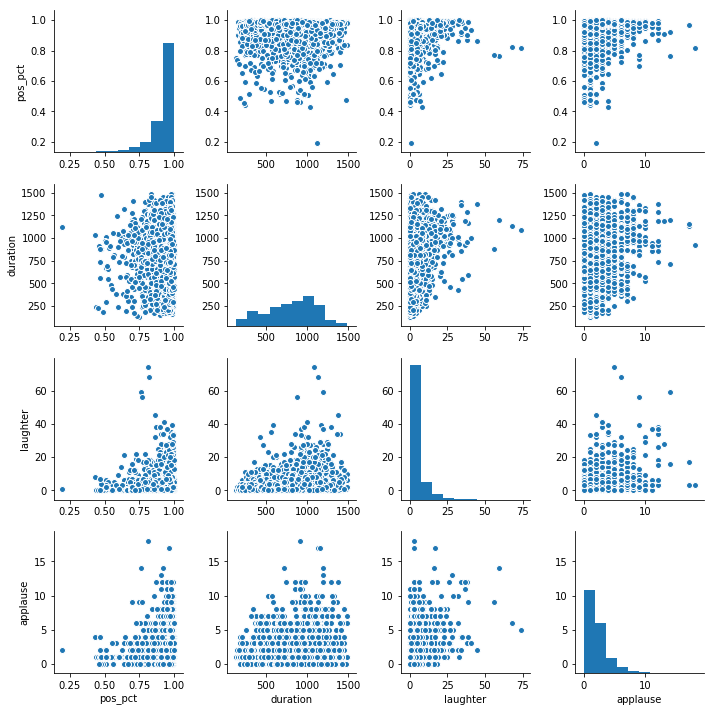

In [71]:
#EDA: Address continuous issues

#1. drop duration greater than 25 minutes
df_ted = df_ted.loc[df_ted['duration'] < 25*60, :].copy()

#2. Change num_speaker to binary for 1 speaker == False, >1 speaker == True
df_ted['speakers'] = df_ted.loc[:, 'num_speaker'].apply(lambda x: x>1)

# show pairplot
_ = sns.pairplot(data=df_ted, vars=['pos_pct', 'duration', 'laughter', 'applause'])
_ = plt.show()

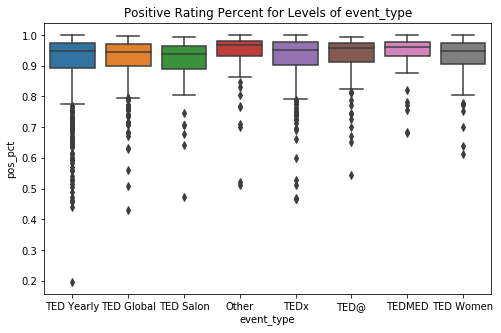

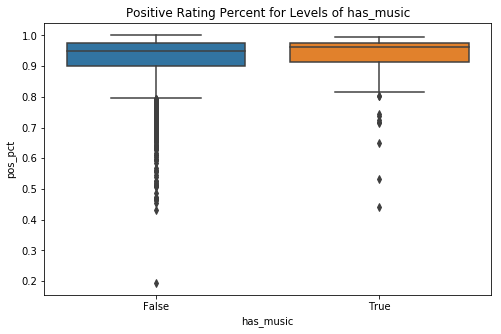

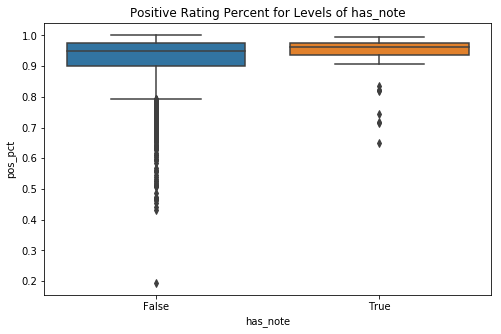

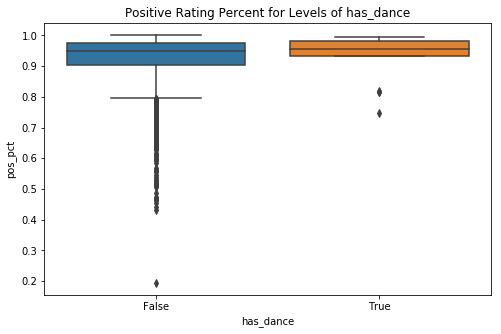

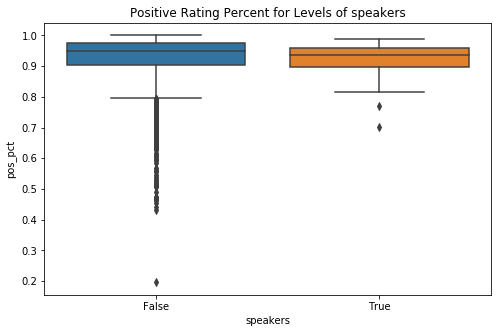

In [72]:
# EDA: Categorical Boxplots
for i in ['event_type', 'has_music', 'has_note', 'has_dance', 'speakers']:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    sns.boxplot(y='pos_pct', x=i, data=df_ted, orient='v')
    plt.title("Positive Rating Percent for Levels of {0}".format(i))
    plt.show()

In [73]:
#df_corr = df_ted.loc[:, [str(i) for i in range(300)]].corr(method='spearman')
#heat = sns.heatmap(df_corr, annot=True, cmap=sns.color_palette("GnBu_d"))
#heat = plt.title("Spearman Correlation for Continuous Data")
#heat = plt.show()

The charts above show that the positive rating percent has a similar distribution for different levels of categorical data, but some categories have more low-rated talks than others.

---

## <a id='#4 Modeling'>4. Modeling</a>

Now that the data has been cleaned and investigated, it can finally be modeled using multiple linear regression. The goal is to find a formula that can be used to accurately predict the positive rating percent of a talk, given its predictor variables. 

--Information about modeling, cross-validation, and RMSE.--

To do this, the data must be broken into randomly-assigned train/test groups (70/30).


In [141]:
import itertools
import numpy as np
from operator import itemgetter
from scipy.stats import spearmanr
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

# Separate data
predictors = ['duration', 'laughter', 'applause', 'event_type', 'has_music', 'has_dance', 'has_note', 'speakers']
predictors += [str(i) for i in list(range(300))]
cats = ['has_note', 'has_music', 'has_dance', 'speakers', 'event_type']
df_cat = pd.get_dummies(df_ted.loc[:, predictors + ['pos_pct']], columns=cats, drop_first=True)
X = df_cat.copy()
X = X.drop('pos_pct', axis=1)
y = df_cat.loc[:, 'pos_pct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [142]:
# Training

# Fit intercept model
int_array_train = np.array([1]*1640).reshape(-1, 1)
intercept = LinearRegression().fit(int_array_train, y_train)
int_train_predict = intercept.predict(int_array_train)
print("Intercept Training RMSE:", np.sqrt(metrics.mean_squared_error(y_train, int_train_predict)))
print("")

# Find best model excluding word vectors
no_word_cols = [i for i in list(X_train.keys()) if i not in [str(j) for j in range(300)]]
no_word_model = RFECV(LinearRegression(), scoring='neg_mean_squared_error', cv=10)
no_word_model_fit = no_word_model.fit(X_train.loc[:, no_word_cols], y_train)
no_word_best_vars = list()
for j in range(len(no_word_model_fit.ranking_)):
    if no_word_model_fit.ranking_[j] == 1:
        no_word_best_vars.append(no_word_cols[j])
no_word_scores = cross_val_score(LinearRegression(),
                                X_train.loc[:, no_word_best_vars],
                                y_train,
                                cv=10,
                                scoring='neg_mean_squared_error')
print("No Word Vectors RMSE:", np.sqrt(-no_word_scores).mean())
print("Variables Used:", no_word_best_vars)
print("")

# Find best model using only word vectors
word_cols = [str(j) for j in range(300)]
word_model = RFECV(LinearRegression(), scoring='neg_mean_squared_error', cv=10)
word_model_fit = word_model.fit(X_train.loc[:, word_cols], y_train)
word_best_vars = list()
for j in range(len(word_model_fit.ranking_)):
    if word_model_fit.ranking_[j] == 1:
        word_best_vars.append(word_cols[j])
word_scores = cross_val_score(LinearRegression(),
                                X_train.loc[:, word_best_vars],
                                y_train,
                                cv=10,
                                scoring='neg_mean_squared_error')
print("Only Word Vectors RMSE:", np.sqrt(-word_scores).mean())
print("Variables Used:", word_best_vars)
print("")

# Find best overall model
overall_model = RFECV(LinearRegression(), scoring='neg_mean_squared_error', cv=10)
overall_model_fit = word_model.fit(X_train, y_train)
overall_best_vars = list()
for j in range(len(overall_model_fit.ranking_)):
    if overall_model_fit.ranking_[j] == 1:
        overall_best_vars.append(X_train.keys()[j])
overall_scores = cross_val_score(LinearRegression(),
                                X_train.loc[:, overall_best_vars],
                                y_train,
                                cv=10,
                                scoring='neg_mean_squared_error')
print("Overall Model RMSE:", np.sqrt(-overall_scores).mean())
print("Variables Used:", overall_best_vars)

Intercept Training RMSE: 0.08790200719037311

No Word Vectors RMSE: 0.08613782169161391
Variables Used: ['duration', 'laughter', 'applause', 'has_note_True', 'has_music_True', 'has_dance_True', 'speakers_True', 'event_type_TED Global', 'event_type_TED Salon', 'event_type_TED Women', 'event_type_TED Yearly', 'event_type_TED@', 'event_type_TEDMED', 'event_type_TEDx']

Only Word Vectors RMSE: 0.08145075473909102
Variables Used: ['26', '45', '55', '64', '69', '71', '82', '116', '122', '137', '139', '172', '185', '186', '191', '214', '227', '228', '232', '240', '262', '263', '271', '279', '287']

Overall Model RMSE: 0.08226758967475466
Variables Used: ['laughter', 'applause', '26', '71', '89', '189', '201', '214', '225', '227', '259', '262', '263', 'has_music_True', 'speakers_True', 'event_type_TED Global', 'event_type_TED Salon', 'event_type_TED Women', 'event_type_TED Yearly', 'event_type_TED@', 'event_type_TEDMED', 'event_type_TEDx']


In [143]:
# Testing

# Intercept Model
intercept_array_test = np.array([1]*703).reshape(-1, 1)
intercept_test = intercept.predict(intercept_array_test)
intercept_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, intercept_test))
print("Intercept Test RMSE:", intercept_test_rmse)
print("")

# No Word Model
no_word_train_model = LinearRegression().fit(X_train.loc[:, no_word_best_vars], y_train)
no_word_test = no_word_train_model.predict(X_test.loc[:, no_word_best_vars])
no_word_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, no_word_test))
print("No Word Vector Test RMSE:", no_word_test_rmse)
print("")

# OnlyWord Model
word_train_model = LinearRegression().fit(X_train.loc[:, word_best_vars], y_train)
word_test = word_train_model.predict(X_test.loc[:, word_best_vars])
word_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, word_test))
print("Only Word Vector Test RMSE:", word_test_rmse)
print("")

# Overall Model
overall_train_model = LinearRegression().fit(X_train.loc[:, overall_best_vars], y_train)
overall_test = overall_train_model.predict(X_test.loc[:, overall_best_vars])
overall_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, overall_test))
print("Overall Test RMSE:", overall_test_rmse)
print("")

Intercept Test RMSE: 0.08036848780545676

No Word Vector Test RMSE: 0.07826609636971808

Only Word Vector Test RMSE: 0.07632722986520199

Overall Test RMSE: 0.07492189680154376



-- Blurb explaining what this is and why it matters --

-- Scatter plots showing accuracy (or lack thereof) --

-- How all this mess could be better --